Po pierwsze, musimy zaimportować dane. Pobierzmy sobie zatem zbiory z UCL i spójrzmy na nie (tam trzeba gdzieniegdzie zamienić klasy ze słowa na wartość liczbową). Po pobraniu pobierzmy jeden ze zbiorów (wina) do zeszytu.

In [1]:
import csv

def loadCsv(filename):
    lines = csv.reader(open(filename, "r"))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    return dataset

filename = 'wine.data.csv'
dataset = loadCsv(filename)

 Następnie musimy wydzielić klasę jako osobny label

In [2]:
def separateClass(dataset):
    target = []
    for i in range(len(dataset)):
        target.append(dataset[i][0])
        del dataset[i][0]
    return dataset,target


data, target=separateClass(dataset)

Możemy już przejść do zdefiniowania modelu i jego walidacji (zobacz jakie to proste!)

In [14]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

mnb = MultinomialNB()
predicted = cross_val_predict(mnb, data, target, cv=8)
print(confusion_matrix(target,predicted))

[[52  5  2]
 [ 3 60  8]
 [ 1  6 41]]


In [15]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

gnb = GaussianNB()
predicted = cross_val_predict(gnb, data, target, cv=8)
print(confusion_matrix(target,predicted))

[[57  2  0]
 [ 2 66  3]
 [ 0  0 48]]


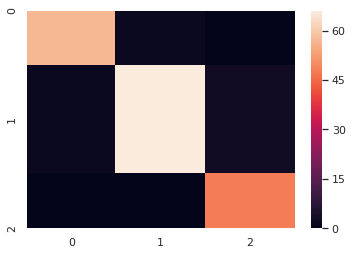

In [12]:
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(target,predicted))
plt.show()

Miary poprawności działania

In [21]:
print("Accuracy: ",accuracy_score(target,predicted))
print("Precision: ",precision_score(target,predicted,average='macro'))
print("Recall: ",recall_score(target,predicted,average=None))
print("F1SCORE: ",f1_score(target,predicted,average=None))
print("Number of mislabeled points out of a total %d points : %d" % (len(data), (target != predicted).sum()))

Accuracy:  0.9606741573033708
Precision:  0.959288800265869
Recall:  [0.96610169 0.92957746 1.        ]
F1SCORE:  [0.96610169 0.94964029 0.96969697]
Number of mislabeled points out of a total 178 points : 7


Teraz zrób to samo dla zbioru glass

A na co się przydaje ta dyskretyzacja? Sprawdźmy!

In [26]:
import numpy as np
import pandas as pd

def equalLength(data,numberOfPartitions):
    datanp=np.vstack(data)
    d_range = np.zeros((datanp.shape[1], 2))
    for i in range(datanp.shape[1]):
        d_range[i][0] = min(datanp[:, i])
        d_range[i][1] = max(datanp[:, i])
    bins = np.empty((numberOfPartitions, datanp.shape[1]))
    for j in range(datanp.shape[1]):
        for i in range(numberOfPartitions):
            bins[i][j] = d_range[j][0] + i * (d_range[j][1] - d_range[j][0]) / numberOfPartitions
        indices = np.digitize(datanp[:, j], bins[:, j]) - 1
        for k in range(len(indices)):
            datanp[k][j] = bins[indices[k]][j]
    return datanp

def equalFrequency(data, numberOfPartitions):
    datanp=np.vstack(data)
    for i in range(datanp.shape[1]):
        indices, bins = pd.qcut(datanp[:, i], numberOfPartitions, labels=False, retbins=True, duplicates='drop')
        for k in range(len(indices)):
            datanp[k][i] = bins[indices[k]]
    return datanp

def histDivision(data):
    datanp = np.vstack(data)
    for i in range(datanp.shape[1]):
        _, bins = np.histogram(datanp[:, i], bins='fd')
        indices = np.digitize(datanp[:, i], bins) - 1
        for j in range(len(indices)):
            datanp[j][i] = bins[indices[j]]
    return datanp

In [27]:
data=equalLength(data,5)
data=equalFrequency(data, 5)
data=histDivision(data)